In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

This dataset contains a comprehensive collection of 15,000 images (each 256x256 pixels) depicting various recyclable materials, general waste, and household items across 30 distinct categories.

import os
from PIL import Image
import numpy as np

def compute_mean_std(image_folder):
    """Compute mean and std per channel for all images in image_folder (RGB), including subfolders."""
    channel_sum = np.zeros(3)
    channel_sum_sq = np.zeros(3)
    num_pixels = 0

    for root, _, files in os.walk(image_folder):
        for fname in files:
            if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(root, fname)
            img = Image.open(img_path).convert('RGB')
            img_np = np.array(img, dtype=np.float32) / 255.0
            num_pixels += img_np.shape[0] * img_np.shape[1]
            channel_sum += img_np.sum(axis=(0,1))
            channel_sum_sq += (img_np ** 2).sum(axis=(0,1))

    mean = channel_sum / num_pixels
    std = np.sqrt(channel_sum_sq / num_pixels - mean**2)
    return mean, std

mean, std = compute_mean_std("../data/images")  # top-level folder
print("mean:", mean)
print("std:", std)

mean: [0.74856972 0.72743281 0.70510449]
std: [0.30954896 0.31524588 0.33628213]


dataset has values around 0.7–0.75 for mean, which is expected for images dominated by bright backgrounds or lighter materials.

std values around 0.31–0.33 mean the pixel values vary moderately around the mean.

In [33]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(256, padding=16),
    transforms.RandomRotation(degrees=30), #This rotates the image by a random angle between –30 and +30 degrees.
    transforms.ToTensor(),
    transforms.Normalize((0.74856972, 0.72743281, 0.70510449), (0.30954896, 0.31524588, 0.33628213))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.74856972, 0.72743281, 0.70510449), (0.30954896, 0.31524588, 0.33628213))
])

In [ ]:
# TODO: Load Datasets (1 mark)
data_dir = "../data/images"  # top-level folder containing all categories
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_test)

# -----------------------------
# 3. Split per class
# -----------------------------
random.seed(42)  # for reproducibility

train_indices = []
test_indices = []

class_to_indices = {i: [] for i in range(len(full_dataset.classes))}
for idx, (_, label) in enumerate(full_dataset.samples):
    class_to_indices[label].append(idx)

for indices in class_to_indices.values():
    n_total = len(indices)
    n_test = int(0.2 * n_total)
    shuffled = indices.copy()
    random.shuffle(shuffled)
    test_indices.extend(shuffled[:n_test])
    train_indices.extend(shuffled[n_test:])

# -----------------------------
# 4. Create Subset datasets
# -----------------------------
class TransformSubset(Subset):
    def __init__(self, subset, transform):
        # If subset is another Subset, flatten indices
        if isinstance(subset, Subset):
            dataset = subset.dataset
            indices = [subset.indices[i] for i in range(len(subset))]
        else:
            dataset = subset
            indices = list(range(len(dataset)))
        super().__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        x, y = super().__getitem__(idx)
        if self.transform:
            x = self.transform(x)
        return x, y


train_dataset_full = TransformSubset(Subset(full_dataset, train_indices), transform_train)
test_dataset = TransformSubset(Subset(full_dataset, test_indices), transform_test)

# TODO: Split train into train + validation
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

val_dataset = TransformSubset(val_dataset, transform_test)

# TODO: Data loaders 
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# -----------------------------
# 2. Load full dataset
# -----------------------------
data_dir = "../data/images"
full_dataset = datasets.ImageFolder(root=data_dir, transform=None)  # no transform yet

# -----------------------------
# 3. Split indices per class
# -----------------------------
random.seed(42)

train_indices, test_indices = [], []
class_to_indices = {i: [] for i in range(len(full_dataset.classes))}
for idx, (_, label) in enumerate(full_dataset.samples):
    class_to_indices[label].append(idx)

for indices in class_to_indices.values():
    n_total = len(indices)
    n_test = int(0.2 * n_total)
    shuffled = indices.copy()
    random.shuffle(shuffled)
    test_indices.extend(shuffled[:n_test])
    train_indices.extend(shuffled[n_test:])

# -----------------------------
# 4. Split train into train + val
# -----------------------------
train_size = int(0.8 * len(train_indices))
val_size = len(train_indices) - train_size
random.shuffle(train_indices)
train_split_indices = train_indices[:train_size]
val_split_indices = train_indices[train_size:]

# -----------------------------
# 5. Create subsets with directory-level transform
# -----------------------------
train_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=transform_train), train_split_indices)
val_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=transform_test), val_split_indices)
test_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=transform_test), test_indices)

# -----------------------------
# 6. DataLoaders
# -----------------------------
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
# TODO: Define CNN Model (3 marks)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Adaptive pooling (output size 4x4)
        self.adapt = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 30)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Adaptive pooling → forces output to 4x4
        x = self.adapt(x)

        # Flatten
        x = x.view(x.size(0),-1)
        
        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Create model and print summary
cnn_model = CNN().to(device)
print("CNN Model Summary:")
print(cnn_model)
print(f"Total parameters: {sum(p.numel() for p in cnn_model.parameters())}")

CNN Model Summary:
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adapt): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=30, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Total parameters: 1157726


In [37]:
# TODO: Define loss criterion and optimizer (2 marks)
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [38]:
# TODO: Training loop (3 marks)
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

In [39]:
# TODO: Validation loop (2 marks)
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [40]:
# TODO: Create plotting functions (2 marks)
def plot_losses(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues')
    plt.xticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

In [48]:
# TODO: Run Training and validation loops for CNN (2 marks)
cnn_train_losses = []
cnn_val_losses = []
cnn_train_accs = []
cnn_val_accs = []

epochs = 5

print("Training CNN...")
for epoch in range(epochs):
    train_loss, train_acc = train(cnn_model, train_loader, cnn_optimizer, criterion, device)
    val_loss, val_acc = validate(cnn_model, val_loader, criterion, device)
    
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)
    cnn_train_accs.append(train_acc)
    cnn_val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Training CNN...
Epoch 1/5:
  Train Loss: 3.0463, Train Acc: 13.73%
  Val Loss: 2.7287, Val Acc: 22.88%
Epoch 2/5:
  Train Loss: 2.6168, Train Acc: 25.25%
  Val Loss: 2.5106, Val Acc: 29.58%
Epoch 3/5:
  Train Loss: 2.4148, Train Acc: 30.45%
  Val Loss: 2.3121, Val Acc: 33.79%
Epoch 4/5:
  Train Loss: 2.2629, Train Acc: 34.88%
  Val Loss: 2.1922, Val Acc: 38.29%
Epoch 5/5:
  Train Loss: 2.1156, Train Acc: 38.72%
  Val Loss: 2.1269, Val Acc: 39.62%


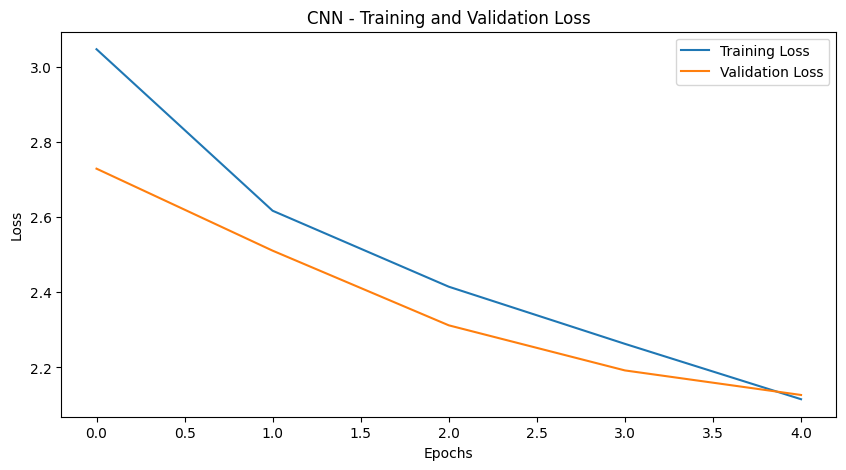

In [49]:
# TODO: Plot losses for CNN 
plot_losses(cnn_train_losses, cnn_val_losses, "CNN")

In [50]:
# TODO: Test loop (3 marks)
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

print("Testing CNN...")
cnn_test_loss, cnn_test_acc = test(cnn_model, test_loader, device)
print(f"CNN Test Loss: {cnn_test_loss:.4f}, Test Accuracy: {cnn_test_acc:.2f}%")

Testing CNN...
CNN Test Loss: 2.1075, Test Accuracy: 40.30%


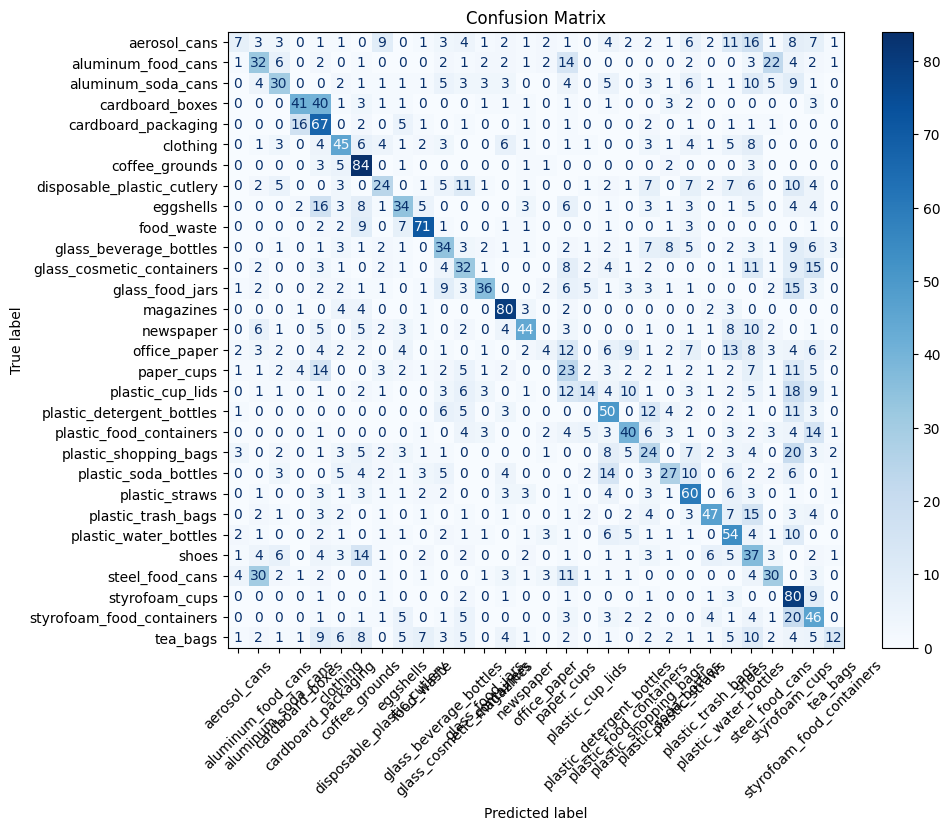

In [51]:
# Plot confusion matrix for the best model
class_names = full_dataset.classes

# Use CNN as it typically performs better
plot_confusion_matrix(cnn_model, test_loader, device, class_names)